<a href="https://colab.research.google.com/github/Jeong-ki-hun/Section2_Project/blob/main/%08AI_11_%EC%A0%95%EA%B8%B0%ED%9B%88(Section2_Project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders
!pip install shap
!pip install pandas_profiling
!pip install eli5
!pip install pdpbox
!pip install matplotlib.pyplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


# 라이브러리 호출

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rc('font', family='NanumBarunGothic') 
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import plot_confusion_matrix
import sklearn
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, OneHotEncoder
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import shap
from pdpbox.pdp import pdp_interact_plot,pdp_plot,pdp_isolate,pdp_interact

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) 데이터 선정 이유 및 문제 정의

문제 정의 및 선정이유

중고차시장은 점점 커지며 대기업들까지도 진출하고있다.

하지만 소비자들은 중고차 시세에 대해 잘 알지못하는 편이다.

또한 중고차의 어떤 부분을 포기해야 저렴한 중고차를 구매 할 수 있지는 알기 위함과 중고차 시세 대해 알수 있다면 합리적인 가격으로 구매가능하며 보다 불편함없이 내가원하는 중고차를 구매할 수 있기 때문에 이데이터셋을 선택하였습니다.


## 데이터는 캐글의 영국 중고차데이터세트(경쟁형식)을 활용하였습니다.

컬럼설명


brand : 브랜드

model : 자동차 모델

year : 년식


transmission : 변속기


mileage : 주행거리


fuelType : 연료종류


tax : 세금


mpg : 연비


engineSize : 엔진사이즈


price:가격



출처 : https://www.kaggle.com/datasets/kukuroo3/used-car-price-dataset-competition-format

In [4]:
x_te = pd.read_csv('/content/drive/MyDrive/archive (14)/X_test.csv',encoding='cp949')
x_tr = pd.read_csv('/content/drive/MyDrive/archive (14)/X_train.csv',encoding='cp949')
y_tr = pd.read_csv('/content/drive/MyDrive/archive (14)/y_train.csv',encoding='cp949')
y_te = pd.read_csv('/content/drive/MyDrive/archive (14)/y_test.csv',encoding='cp949')
tr = pd.merge(x_tr,y_tr,how='inner',on='carID')
ts = pd.merge(x_te,y_te,how='inner',on='carID')
df = pd.concat([tr,ts]).reset_index(drop=True)

## 데이터를 평가지표, 베이스라인모델 선택

가격을 예측하기 위함이므로 회귀문제이다.
그렇기 때문에 타켓인 가격(Price)의 평균값을 베이스라인 모델로 선택하였다.

# 데이터 전처리 및 EDA

In [5]:
df_1 = df.copy()

In [6]:
df.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,13207,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2,31995
1,17314,vauxhall,GTC,2015,Manual,47870,Diesel,125.0,60.1,2.0,7700
2,12342,audi,RS4,2019,Automatic,5151,Petrol,145.0,29.1,2.9,58990
3,13426,vw,Scirocco,2016,Automatic,20423,Diesel,30.0,57.6,2.0,12999
4,16004,skoda,Scala,2020,Semi-Auto,3569,Petrol,145.0,47.1,1.0,16990


우선 필요없는 컬럼인 carid칼럼을 삭제시켜줍니다.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7632 entries, 0 to 7631
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   carID         7632 non-null   int64  
 1   brand         7632 non-null   object 
 2   model         7632 non-null   object 
 3   year          7632 non-null   int64  
 4   transmission  7632 non-null   object 
 5   mileage       7632 non-null   int64  
 6   fuelType      7632 non-null   object 
 7   tax           7632 non-null   float64
 8   mpg           7632 non-null   float64
 9   engineSize    7632 non-null   float64
 10  price         7632 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 656.0+ KB


In [8]:
df.isnull().sum()

carID           0
brand           0
model           0
year            0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
price           0
dtype: int64

In [9]:
df.drop(columns=['carID'],axis=1,inplace=True)

In [10]:
df['brand'].unique()

array(['hyundi', 'vauxhall', 'audi', 'vw', 'skoda', 'merc', 'toyota',
       'bmw', 'ford'], dtype=object)

In [11]:
df['model'].unique()

array([' Santa Fe', ' GTC', ' RS4', ' Scirocco', ' Scala', ' V Class',
       ' Prius', ' M4', ' Camry', ' KA', ' Vivaro', ' CLS Class',
       ' Caravelle', ' Arteon', ' Shuttle', ' I40', ' IX20', ' 6 Series',
       ' GL Class', ' S Class', ' S3', ' Yeti', ' Galaxy', ' Puma',
       ' Edge', ' A8', ' SLK', ' Kamiq', ' RS6', ' CLA Class',
       ' Land Cruiser', ' M Class', ' Q8', ' i3', ' Verso', ' Mustang',
       ' IX35', ' Amarok', ' Avensis', ' Grand Tourneo Connect',
       ' Antara', ' Tourneo Connect', ' Beetle', ' X4', ' CC', ' GT86',
       ' X-CLASS', ' I800', ' i8', ' Caddy Maxi Life', ' Combo Life',
       ' Rapid', ' SQ7', ' Grand C-MAX', ' Tourneo Custom', ' California',
       ' Agila', ' A7', ' Zafira Tourer', ' G Class', ' Tiguan Allspace',
       ' X6', ' M2', ' X7', ' 7 Series', ' Z4', ' RS5', ' Hilux',
       ' GLS Class', ' GLB Class', ' M5', ' RS3', ' Caddy Life', ' SQ5',
       ' Supra', ' 8 Series', ' Fusion', ' M6', ' M3', ' Jetta', ' S4',
       ' R8', ' PRO

### 데이터 시각화

제조사별 평균단가

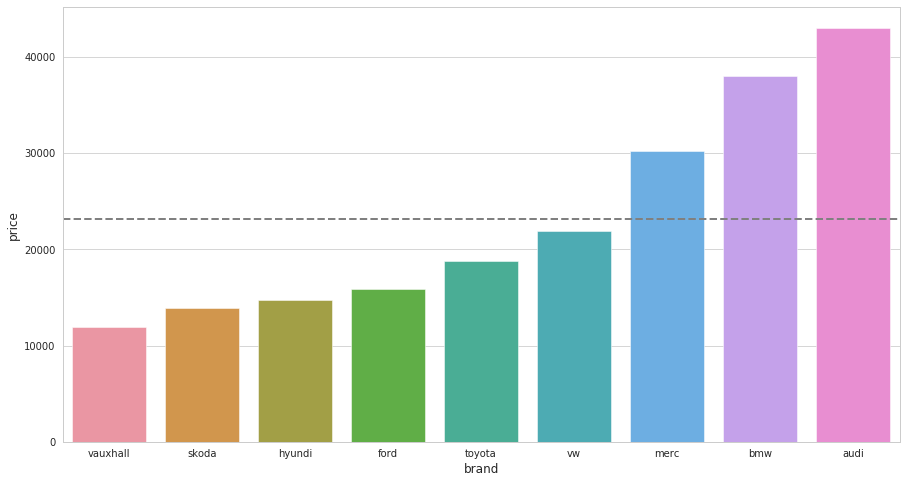

In [12]:
brand = df.groupby('brand')['price'].mean().to_frame().sort_values(by='price')
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=brand.index,y='price',data=brand)
plt.axhline(y = brand['price'].mean(), color = 'gray', linestyle = '--', linewidth = 2)

연식별 평균단가

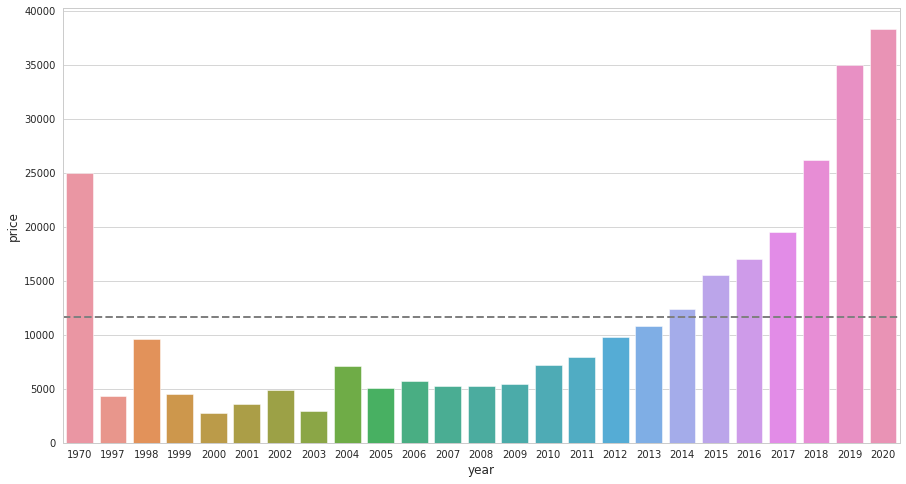

In [13]:
year = df.groupby('year')['price'].mean().to_frame().sort_values(by='price')
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=year.index,y='price',data=year)
plt.axhline(y = year['price'].mean(), color = 'gray', linestyle = '--', linewidth = 2)

In [14]:
df.loc[df['year']==1970]

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
6782,merc,M Class,1970,Automatic,14000,Diesel,305.0,39.2,0.0,24999


In [15]:
df.loc[df['year']==1998]

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
3014,merc,S Class,1998,Automatic,43534,Petrol,265.0,23.3,6.0,19990
4578,merc,SLK,1998,Automatic,113557,Petrol,265.0,32.1,2.3,1990
6154,toyota,Land Cruiser,1998,Manual,100000,Diesel,265.0,23.9,4.2,19990
6984,merc,SLK,1998,Automatic,99300,Petrol,265.0,32.1,2.3,1990
7045,bmw,Z3,1998,Manual,56500,Petrol,270.0,35.3,1.9,3950


변속유형별 평균단가

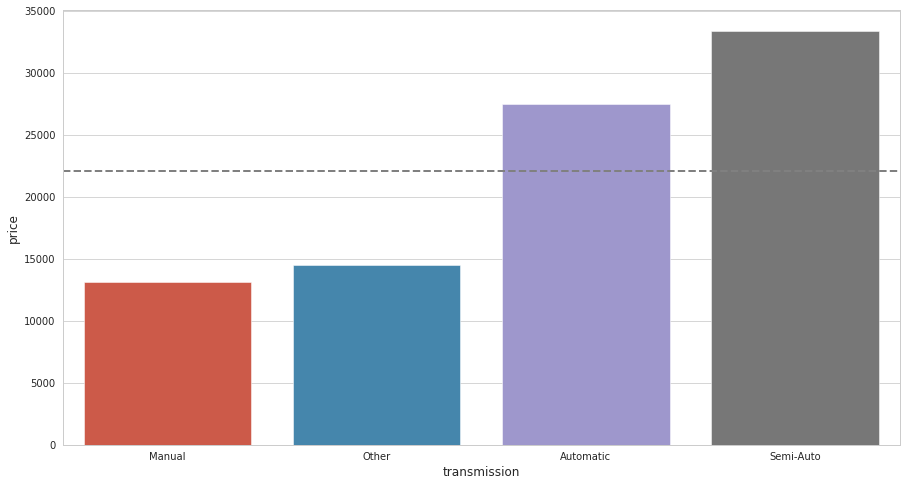

In [16]:
tran = df.groupby('transmission')['price'].mean().to_frame().sort_values(by='price')
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=tran.index,y='price',data=tran)
plt.axhline(y = tran['price'].mean(), color = 'gray', linestyle = '--', linewidth = 2)

연료 유형별 평균단가

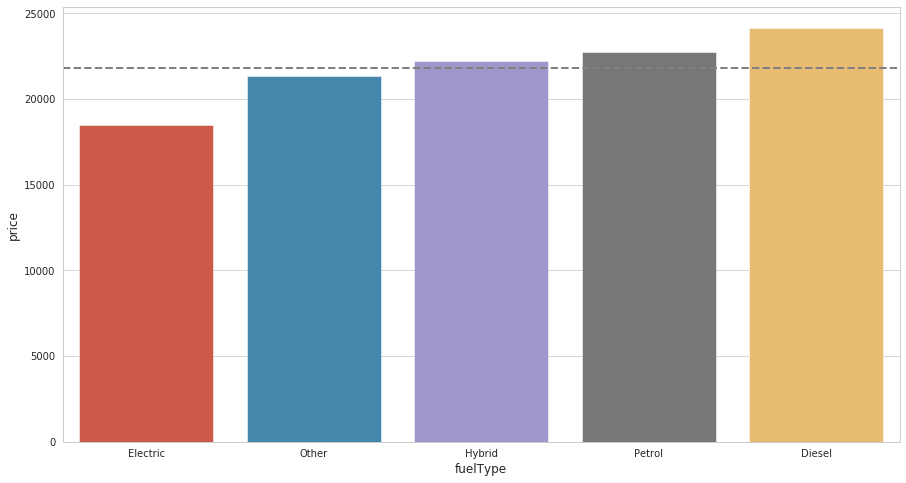

In [17]:
fuel = df.groupby('fuelType')['price'].mean().to_frame().sort_values(by='price')
fig = plt.figure(figsize=(15, 8))
sns.barplot(x=fuel.index,y='price',data=fuel)
plt.axhline(y = fuel['price'].mean(), color = 'gray', linestyle = '--', linewidth = 2)

수치형컬럼들의 상관관계분석 히트맵

In [18]:
df.corr()

,year,mileage,tax,mpg,engineSize,price
year,1.000000,-0.753325,-0.200159,-0.040006,0.032041,0.498388
mileage,-0.753325,1.000000,0.124939,0.075106,-0.018777,-0.486950
tax,-0.200159,0.124939,1.000000,-0.311065,0.456532,0.142273
mpg,-0.040006,0.075106,-0.311065,1.000000,-0.353857,-0.178982
engineSize,0.032041,-0.018777,0.456532,-0.353857,1.000000,0.623995
price,0.498388,-0.486950,0.142273,-0.178982,0.623995,1.000000


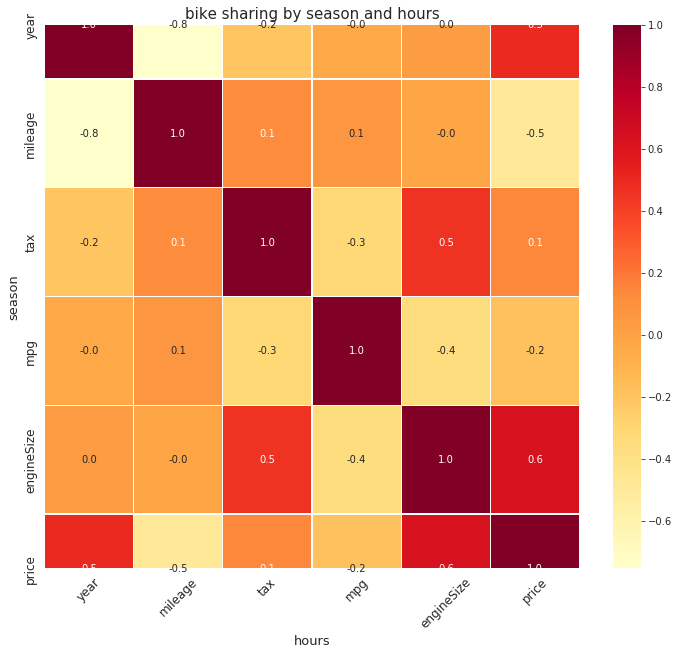

In [19]:
fig, ax = plt.subplots(figsize=(12,10))

sns.heatmap(df.corr(), # 위에서 전처리한 데이터프레임
            annot = True, # 숫자 표시 여부
            ax = ax, # 히트맵을 그릴 격자
            linewidths = 0.4, # 선의 굵기
            linecolor = 'white', # 선의 색깔
            fmt = '.1f', # 소수점 포맷팅 형태
            cmap = 'YlOrRd') # colormap 형태

plt.title('bike sharing by season and hours', size = 15)
plt.ylabel('season', size = 13)
plt.xlabel('hours', size = 13) 

plt.xticks(rotation=45, size = 12)
plt.yticks(size=12) 
plt.show()

## 4) 머신러닝 방식 적용

In [20]:
objlist = df.select_dtypes(include = "object").columns
label = LabelEncoder()
df[objlist] = df[objlist].apply(label.fit_transform)

In [21]:
target = df['price']
features = df.drop(columns='price')

In [22]:
x_train,x_test,y_train,y_test = train_test_split(features,target,test_size=0.2,random_state=42)

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(6105, 9) (1527, 9) (6105,) (1527,)


기준모델 생성

In [23]:
predict = df['price'].mean()

In [24]:
price=pd.DataFrame(df['price'])

In [25]:
price['predict'] = predict

In [26]:
price

,price,predict
0,31995,23579.922825
1,7700,23579.922825
2,58990,23579.922825
3,12999,23579.922825
4,16990,23579.922825
...,...,...
7627,28990,23579.922825
7628,17450,23579.922825
7629,21995,23579.922825
7630,18700,23579.922825


In [27]:
r2_score(price['price'], price['predict'])

0.0

릿지모형

In [28]:
dists = { 
    'alpha': [0.1,1,10,100],}

clf = RandomizedSearchCV(
    Ridge(), 
    param_distributions=dists, 
    n_iter=100, 
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

clf.fit(x_train, y_train);
print('최적 하이퍼파라미터: ', clf.best_params_)
print('R2: ', clf.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
최적 하이퍼파라미터:  {'alpha': 10}
R2:  0.676871551817235


라쏘

In [29]:
dists = { 
    'alpha': [0.1,1,10,100], }

clf_1 = RandomizedSearchCV(
    Lasso(), 
    param_distributions=dists, 
    n_iter=100, 
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

clf_1.fit(x_train, y_train);
print('최적 하이퍼파라미터: ', clf_1.best_params_)
print('R2: ', clf_1.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
최적 하이퍼파라미터:  {'alpha': 10}
R2:  0.6768683545562992


엘라스틱넷

In [30]:
dists = { 
    'alpha': [0.1,1,10,100]}

clf_2 = RandomizedSearchCV(
    ElasticNet(), 
    param_distributions=dists, 
    n_iter=100, 
    cv=5,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

clf_2.fit(x_train, y_train);
print('최적 하이퍼파라미터: ', clf_2.best_params_)
print('R2: ', clf_2.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
최적 하이퍼파라미터:  {'alpha': 0.1}
R2:  0.673399466397983


In [31]:
dists = {
    'n_estimators': randint(50, 1000),
    'max_depth': randint(1,50), 
    'min_samples_leaf' : randint(1, 50),
    'max_features': ['sqrt','log2',None]}

clf_3 = RandomizedSearchCV(
    RandomForestRegressor(random_state=2), 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='r2',  
    verbose=1,
    n_jobs=-1
)

clf_3.fit(x_train, y_train)
print('최적 하이퍼파라미터: ', clf_3.best_params_)
print('R2: ', clf_3.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
최적 하이퍼파라미터:  {'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 712}
R2:  0.9488575014229723


In [32]:
dists = {
    'max_depth': randint(1,50), 
    'min_samples_leaf' : randint(1, 50),
    'max_features': ['sqrt','log2',None]
}

clf_4 = RandomizedSearchCV(
    DecisionTreeRegressor(), 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='r2',  
    verbose=1,
    n_jobs=-1
)

clf_4.fit(x_train, y_train)
print('최적 하이퍼파라미터: ', clf_4.best_params_)
print('R2: ', clf_4.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
최적 하이퍼파라미터:  {'max_depth': 35, 'max_features': None, 'min_samples_leaf': 7}
R2:  0.9039956220870954


In [33]:
print('릿지의 R2 Score :', clf.best_estimator_.score(x_test, y_test))
print('라쏘의 R2 Score :', clf_1.best_estimator_.score(x_test, y_test))
print('엘라스틱넷의 R2 Score :', clf_2.best_estimator_.score(x_test, y_test))
print('랜덤포레스트의 R2 Score :', clf_3.best_estimator_.score(x_test, y_test))
print('의사결정나무의 R2 Score :', clf_4.best_estimator_.score(x_test, y_test))

model = clf_3.best_estimator_

릿지의 R2 Score : 0.6431853734995936
라쏘의 R2 Score : 0.6430281950916372
엘라스틱넷의 R2 Score : 0.6451459091219385
랜덤포레스트의 R2 Score : 0.9560211718508538
의사결정나무의 R2 Score : 0.9233552991963216


##  머신러닝 모델 해석

In [34]:
model.feature_names = df.drop('price', axis = 1).columns

In [35]:
feat_df= pd.DataFrame({'feature': model.feature_names,'importance':model.feature_importances_*100})

In [36]:
sorted_df=feat_df.sort_values('importance', ascending=False)

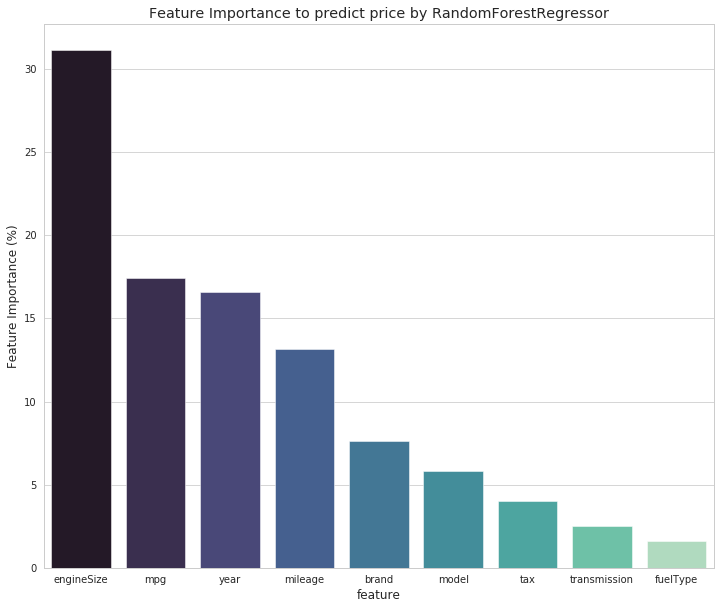

In [48]:
plt.figure(figsize=(12,10))
ax =sns.barplot(y='importance', x='feature', data=sorted_df.head(10), palette='mako')
plt.title('Feature Importance to predict price by RandomForestRegressor')
plt.ylabel('Feature Importance (%)')
plt.show()

100%|===================| 6103/6105 [54:31<00:01]       

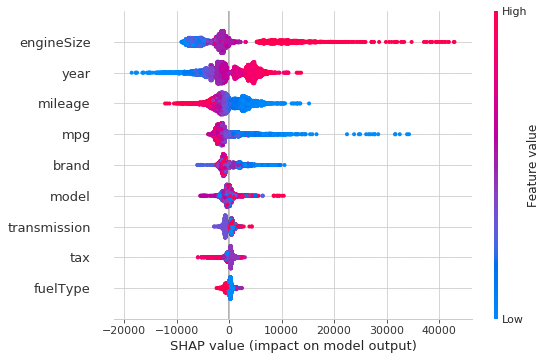

In [38]:
explainer = shap.TreeExplainer(
    model, x_train, feature_names = df.drop('price', axis = 1).columns)
shap_values = explainer.shap_values(x_train, y_train,check_additivity=False)
shap.summary_plot(shap_values, x_train, feature_names=df.drop('price', axis = 1).columns);

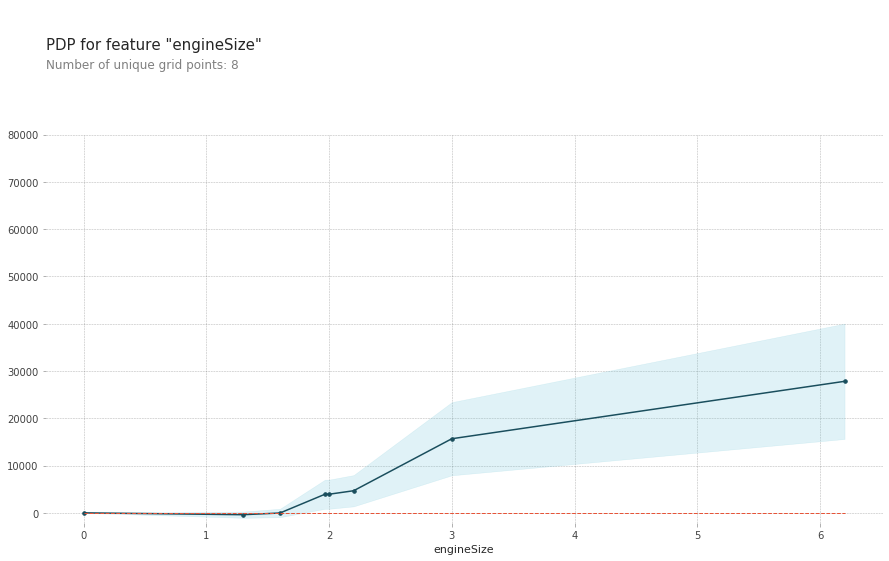

In [39]:
feature = 'engineSize'
pdp_dist = pdp_isolate(model, dataset=x_test, model_features=x_test.columns, feature=feature)
pdp_plot(pdp_dist, feature);

## 모델 예측

In [42]:
df_1.loc[400:401]

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
400,14539,hyundi,I40,2015,Manual,33036,Diesel,20.0,67.3,1.7,9498
401,14534,vw,Beetle,2006,Manual,117000,Diesel,150.0,50.4,1.9,3195


In [43]:
df_1.drop(columns=['carID'],axis=1,inplace=True)
df_1.drop(columns=['price'],axis=1,inplace=True)

In [44]:
df_1[objlist] = df_1[objlist].apply(label.fit_transform)

In [45]:
test = pd.DataFrame(df_1.loc[400]).T
#test=(pd.DataFrame(test,columns=['brand',	'model','year','transmission','mileage','fuelType','tax',	'mpg','engineSize']))
test.head()
model.predict(test)

array([8862.17734936])